In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models, datasets
from torch.utils.data import Dataset, DataLoader

In [4]:
from synthetic_utils import *

In [5]:
from trainer_dataloader import *
from networks import *
from losses import *
from synthetic_dataloader import *

In [6]:
input_size = 96
batch_size = 128
num_workers = 4
num_epochs = 20

In [7]:
cuda = False
pin_memory = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))

Device set: cuda


In [8]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
#             transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
}

In [9]:
# DATA_PATH = '/home/s1791387/diss/gen_shapes/'
DATA_PATH = '/home/var/synthetic_data/gen_shapes/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'valid')
TEST_PATH = os.path.join(DATA_PATH, 'test')

In [10]:
train_df = datasets.ImageFolder(root=TRAIN_PATH, transform=data_transforms['train'])
val_df = datasets.ImageFolder(root=VAL_PATH, transform=data_transforms['val'])
test_df = datasets.ImageFolder(root=TEST_PATH, transform=data_transforms['val'])

In [11]:
# train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
# val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
# test_loader = DataLoader(test_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

In [12]:
gender_train = GenderDataset(train_df)
gender_valid = GenderDataset(val_df)
gender_test = GenderDataset(test_df)

In [13]:
train_loader = DataLoader(gender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(gender_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(gender_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

## Train only encoder first


In [14]:
encoder = LeNet()
classifier = ClassNet()

In [15]:
encoder.to(device)
classifier.to(device)

ClassNet(
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (out_acc): Sigmoid()
)

In [16]:
criterion = nn.BCELoss()
opt_cls = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
opt_enc = optim.Adam(encoder.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_cls = lr_scheduler.StepLR(optimizer=opt_cls, gamma=0.99, step_size=1)
scheduler_enc = lr_scheduler.StepLR(optimizer=opt_enc, gamma=0.99, step_size=1)

In [17]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, 20):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_cls.step()
        scheduler_enc.step()
        # train
        train_loss, train_acc = train_encoder_classifier_epoch(train_loader, encoder,
                                classifier, opt_enc,
                                opt_cls, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_encoder_classifier_epoch(val_loader, encoder, classifier,
                                 criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 2.063 (2.063)	Loss 0.6980 (0.6980)	Accuracy 0.5156 (0.5156)
Batch: [10/40]	Time 0.060 (0.421)	Loss 0.4593 (0.5841)	Accuracy 0.8750 (0.7330)
Batch: [20/40]	Time 0.761 (0.389)	Loss 0.2894 (0.4814)	Accuracy 0.9219 (0.8039)
Batch: [30/40]	Time 0.212 (0.342)	Loss 0.1921 (0.4223)	Accuracy 0.9141 (0.8332)
----------


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test: [0/4]	Time 1.642 (1.642)	Loss 0.0462 (0.0462)	Accuracy 0.9922 (0.9922)
Avg validation loss: 0.08865507093071938 	 Accuracy: 0.964
--------------------
Epoch 0/20	Time 15.100 sec (15.100 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 1.724 (1.724)	Loss 0.1462 (0.1462)	Accuracy 0.9297 (0.9297)
Batch: [10/40]	Time 0.051 (0.442)	Loss 0.0685 (0.0928)	Accuracy 0.9688 (0.9652)
Batch: [20/40]	Time 0.886 (0.405)	Loss 0.0094 (0.0665)	Accuracy 1.0000 (0.9766)
Batch: [30/40]	Time 0.052 (0.359)	Loss 0.0076 (0.0533)	Accuracy 1.0000 (0.9816)
----------
Test: [0/4]	Time 1.535 (1.535)	Loss 0.0214 (0.0214)	Accuracy 1.0000 (1.0000)
Avg validation loss: 0.023540556512773037 	 Accuracy: 0.996
--------------------
Epoch 1/20	Time 15.223 sec (15.162 sec)
--------------------
Epoch: 2/20
Batch: [0/40]	Time 1.735 (1.735)	Loss 0.0078 (0.0078)	Accuracy 1.0000 (1.0000)
Batch: [10/40]	Time 0.060 (0.402)	Loss 0.0026 (0.0139)	Accuracy 1.0000 (0.9986)
Batch: [20/40]	Time 0.352 (0.368)	Loss 0.0086 (0.0134)	Accuracy 1.0000 (0.9967)
Batch: [30/40]	Time 0.049 (0.338)	Loss 0.0080 (0.0143)	Accuracy 1.0000 (0.9967)
----------
Test: [0/4]	Time 1.717 (1.717)	Loss 0.0051 (0.0051)	Accuracy 1.0000 (1.0000)
Avg validation loss: 0.013633372

In [18]:
validate_encoder_classifier_epoch(test_loader, encoder, classifier,
                                 criterion, device)

Test: [0/4]	Time 2.283 (2.283)	Loss 0.0003 (0.0003)	Accuracy 1.0000 (1.0000)


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


(0.016707477256190033, 0.996)

In [19]:
import matplotlib.pyplot as plt

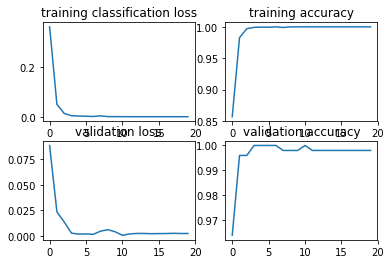

In [20]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)

In [21]:
from synthetic_dataloader import *

In [22]:
shape_gender_train = ShapeGenderDataset(train_df)
shape_gender_val = ShapeGenderDataset(val_df)
shape_gender_test = ShapeGenderDataset(test_df)

In [23]:
reps = []
shapes = []
colors= []
encoder.eval()
with torch.no_grad():
    for i in range(len(train_df)):
        img, shape, color = shape_gender_train[i]
        img = img.to(device).float()
        img.unsqueeze_(0)
        encoding = encoder(img)
        reps.append(encoding[0].cpu().numpy())
        shapes.append(shape)
        colors.append(color)
        if i == 0: 
            print(i)

0


In [24]:
y_num = pd.DataFrame(shapes)
s = pd.DataFrame(colors)
X = pd.DataFrame(reps)

In [25]:
import matplotlib.cm as cm
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
plt.style.use('bmh')

In [26]:
colors = cm.Dark2(np.linspace(0, 1, len(train_df.classes)))

In [27]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [28]:
X_pca = PCA(n_components=50).fit_transform(X, X)
tsne = TSNE(n_components=2, init='random', random_state=0)
# X_r = tsne.fit_transform(X)
X_r = tsne.fit_transform(X_pca)

In [29]:
train_df.class_to_idx

{'circle': 0, 'rectangle': 1}

Saved to: indep_adv_tsne_train_y.pdf


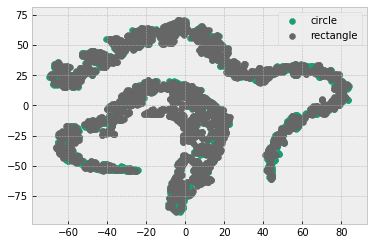

In [30]:
plt.figure(figsize=(10,10))
plt.scatter(X_r[(y_num == 0)[0], 0], X_r[(y_num == 0)[0], 1], c=colors[0], label='circle')
plt.scatter(X_r[(y_num == 1)[0], 0], X_r[(y_num == 1)[0], 1], c=colors[1], label='rectangle')
plt.legend()
# plt.show()
out = "indep_adv_tsne_train_y.pdf"
plt.savefig(out)
print("Saved to: {}".format(out))

Saved to: indep_adv_tsne_train_s.pdf


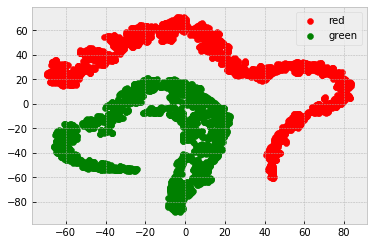

In [31]:
plt.figure(figsize=(10,10))
plt.scatter(X_r[(s == 1)[0], 0], X_r[(s == 1)[0], 1], c='red', label='red')
plt.scatter(X_r[(s == 0)[0], 0], X_r[(s == 0)[0], 1], c='green', label='green')
plt.legend()
out = "indep_adv_tsne_train_s.pdf"
plt.savefig(out)
print("Saved to: {}".format(out))
# plt.show()

In [32]:
reps_test = []
shapes_test = []
colors_test = []
encoder.eval()
with torch.no_grad():
    for i in range(len(test_df)):
        img, shape, color = shape_gender_test[i]
        img = img.to(device).float()
        img.unsqueeze_(0)
        encoding = encoder(img)
        reps_test.append(encoding[0].cpu().numpy())
        shapes_test.append(shape)
        colors_test.append(color)
        if i == 0: 
            print(i)

0


In [33]:
y_num_test = pd.DataFrame(shapes_test)
s_test = pd.DataFrame(colors_test)
X_test = pd.DataFrame(reps_test)

In [34]:
X_pca_test = PCA(n_components=50).fit_transform(X_test, X_test)
tsne_test = TSNE(n_components=2, init='random', random_state=0)
# X_r = tsne.fit_transform(X)
X_r_test = tsne_test.fit_transform(X_pca_test)

In [35]:
colors = cm.Dark2(np.linspace(0, 1, len(train_df.classes)))

Saved to: indep_adv_tsne_test_y.pdf


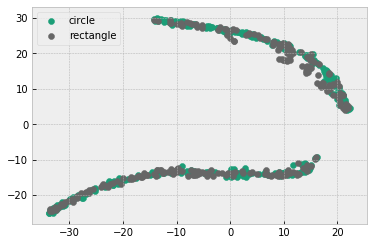

In [36]:
plt.figure(figsize=(10,10))
plt.scatter(X_r_test[(y_num_test == 0)[0], 0], X_r_test[(y_num_test == 0)[0], 1], c=colors[0], label='circle')
plt.scatter(X_r_test[(y_num_test == 1)[0], 0], X_r_test[(y_num_test == 1)[0], 1], c=colors[1], label='rectangle')
plt.legend()
out = "indep_adv_tsne_test_y.pdf"
plt.savefig(out)
print("Saved to: {}".format(out))

Saved to: indep_adv_tsne_test_s.pdf


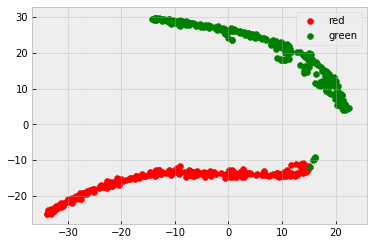

In [37]:
plt.figure(figsize=(10,10))
plt.scatter(X_r_test[(s_test == 1)[0], 0], X_r_test[(s_test == 1)[0], 1], c='red', label='red')
plt.scatter(X_r_test[(s_test == 0)[0], 0], X_r_test[(s_test == 0)[0], 1], c='green', label='green')
plt.legend()
out = "indep_adv_tsne_test_s.pdf"
plt.savefig(out)
print("Saved to: {}".format(out))